In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [32]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-03 17:55:02,389 INFO: Closing external client and cleaning up certificates.


Connection closed.
2025-03-03 17:55:02,418 INFO: Initializing external client
2025-03-03 17:55:02,418 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-03 17:55:03,342 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215642


In [33]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1215642/featurestores/1202294/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [ ]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

In [7]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [9]:
ts_data.tail()

,pickup_hour,pickup_location_id,rides
2443531,2025-03-03 16:00:00+00:00,263,89
2443532,2025-03-03 17:00:00+00:00,263,114
2443533,2025-03-03 18:00:00+00:00,263,116
2443534,2025-03-03 19:00:00+00:00,263,102
2443535,2025-03-03 20:00:00+00:00,263,87


In [10]:
ts_data["pickup_hour"].min()

'2022-01-01 05:00:00+00:00'

In [11]:
ts_data["pickup_hour"].max()

'2025-03-03 20:00:00+00:00'

In [12]:
ts_data_copy = ts_data.copy()

In [35]:
ts_data = ts_data_copy

In [36]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [37]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443536 entries, 0 to 2443535
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 37.3 MB


In [38]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [39]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443536 entries, 0 to 2443535
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 37.3 MB


In [40]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [41]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2022-01-01 05:00:00,2,0,2022-01
1,2022-01-01 06:00:00,2,0,2022-01
2,2022-01-01 07:00:00,2,0,2022-01
3,2022-01-01 08:00:00,2,0,2022-01
4,2022-01-01 09:00:00,2,0,2022-01
...,...,...,...,...
2443531,2025-03-03 16:00:00,263,89,2025-03
2443532,2025-03-03 17:00:00,263,114,2025-03
2443533,2025-03-03 18:00:00,263,116,2025-03
2443534,2025-03-03 19:00:00,263,102,2025-03


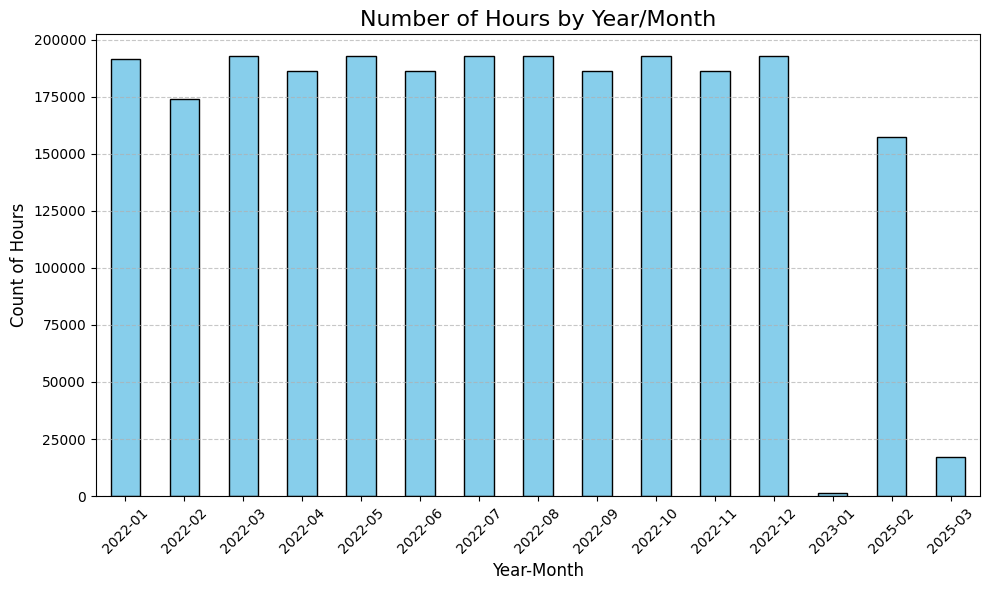

In [42]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [43]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2022-01-01 05:00:00,2,0,2022-01
1,2022-01-01 06:00:00,2,0,2022-01
2,2022-01-01 07:00:00,2,0,2022-01
3,2022-01-01 08:00:00,2,0,2022-01
4,2022-01-01 09:00:00,2,0,2022-01


In [44]:
gte = ts_data["year_month"] >= pd.Period("2022-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2022-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [45]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [46]:
filtered_data.shape

(2267545, 3)

In [47]:
ts_data = filtered_data

In [48]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267545 entries, 0 to 2267544
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 34.6 MB


In [49]:
ts_data.head()["pickup_hour"].values

array(['2022-01-01T05:00:00.000000000', '2022-01-01T06:00:00.000000000',
       '2022-01-01T07:00:00.000000000', '2022-01-01T08:00:00.000000000',
       '2022-01-01T09:00:00.000000000'], dtype='datetime64[ns]')

In [50]:
ts_data

,pickup_hour,pickup_location_id,rides
0,2022-01-01 05:00:00,2,0
1,2022-01-01 06:00:00,2,0
2,2022-01-01 07:00:00,2,0
3,2022-01-01 08:00:00,2,0
4,2022-01-01 09:00:00,2,0
...,...,...,...
2267540,2022-12-31 19:00:00,263,113
2267541,2022-12-31 20:00:00,263,112
2267542,2022-12-31 21:00:00,263,108
2267543,2022-12-31 22:00:00,263,107


In [51]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [52]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-29 05:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2022-01-30 04:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2022-01-31 03:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2022-02-01 02:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2022-02-02 01:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91163,133,136,145,118,136,133,137,117,109,87,...,13,28,52,71,89,92,91,92,2022-12-27 18:00:00,263
91164,121,118,114,128,117,155,152,121,108,115,...,9,14,37,65,64,90,94,92,2022-12-28 17:00:00,263
91165,124,121,136,141,147,141,175,214,182,139,...,4,11,16,41,55,70,85,89,2022-12-29 16:00:00,263
91166,139,128,114,118,145,153,154,181,232,227,...,25,19,10,15,41,48,51,76,2022-12-30 15:00:00,263


In [29]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-27 13:00:00,2
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-28 12:00:00,2
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-29 11:00:00,2
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-30 10:00:00,2


In [53]:
features_copy = features.copy()

In [54]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(91168, 675)

In [55]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-03 17:58:13.518072')

In [56]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(91168, 674)
(91168,)
(0, 674)
(0,)


In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91168 entries, 0 to 91167
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 468.5 MB


In [58]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [59]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171646
[LightGBM] [Info] Number of data points in the train set: 91168, number of used features: 675
[LightGBM] [Info] Start training from score 17.645062


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x3144f1f80>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [60]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [48]:
predictions

array([ 0.16632143,  0.16632143,  0.16632143, ..., 83.42269769,
       75.76323756, 60.66289631])

In [61]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

1.9671


In [62]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['/Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/NYC-Yellow-Taxi/models/lgb_model.pkl']

In [63]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [67]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('/Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/NYC-Yellow-Taxi/models/lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/317266 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2049 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48705 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1215642/models/taxi_demand_predictor_next_hour/1


Model(name: 'taxi_demand_predictor_next_hour', version: 1)

In [68]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-03-03 18:01:57,293 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-03 18:01:57,298 INFO: Initializing external client
2025-03-03 18:01:57,298 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-03 18:01:58,033 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215642


In [69]:
from src.inference import get_model_predictions

In [70]:
preds = get_model_predictions(model, features_copy)

In [72]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
91163,263,101.0
91164,263,109.0
91165,263,104.0
91166,263,93.0


In [73]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.8727
